In [1]:
import numpy as np
import ray

from q1physrl import analyse, train, phys, env
import matplotlib.pyplot as plt

/home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
ray.init()

2020-03-09 09:35:59,499	INFO resource_spec.py:212 -- Starting Ray with 2.05 GiB memory available for workers and up to 1.03 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-09 09:35:59,963	INFO services.py:1083 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.43.49',
 'redis_address': '192.168.43.49:19069',
 'object_store_address': '/tmp/ray/session_2020-03-09_09-35-59_438289_6863/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-09_09-35-59_438289_6863/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-09_09-35-59_438289_6863'}

In [3]:
config = env.Config(
    num_envs=1,
    auto_jump=False,
    time_limit=10,
    key_press_delay=0.3,
    initial_yaw_range=(0, 360),
    max_initial_speed=700,
    zero_start_prob=1.0,
    action_range=1.0,
)

trainer = train.make_trainer(train.make_run_config(config))

2020-03-09 09:36:00,564	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-09 09:36:00,621	ERROR logger.py:184 -- pip install 'ray[tune]' to see TensorBoard files.
2020-03-09 09:36:00,622	WARNING logger.py:286 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2020-03-09 09:36:00,635	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-03-09 09:36:02,982	WARNING worker.py:1058 -- The dashboard on node matt-ThinkPad-X1-Carbon failed with the following error:
Traceback (most recent call last):
  File "/home/matt/ray/python/ray/dashboard/dashboard.py", line 918, in <module>
    redis_password=args.redis_password,
  File "/home/matt/ray/python/ray/dashboard/dashboard.py", line 134, in __init__
    self.setup_routes()
  File "/home/matt/ray/python/ray/dashboard/dashboard.py", line 333, in setup_routes
    build_dir)
FileNotFoundE

(pid=6943) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=6943)   warnings.warn(msg)
(pid=6944) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=6944)   warnings.warn(msg)
(pid=6942) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=6942)   warnings.warn(msg)
(pid=6941) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. You

2020-03-09 09:36:14,817	INFO trainable.py:178 -- _setup took 14.184 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-03-09 09:36:14,828	WARNING util.py:37 -- Install gputil for GPU system monitoring.


In [4]:
# FNAME = '../checkpoints/checkpoint-7867'
# FNAME = '../checkpoints/checkpoint-5199'
# FNAME = '../checkpoints/checkpoint-7781'
# FNAME = '../checkpoints/checkpoint-8718'
# FNAME = '../checkpoints/checkpoint-8765'
# FNAME = '../checkpoints/checkpoint-11625'
# FNAME = '../checkpoints/checkpoint-2458'
# FNAME = '../checkpoints/checkpoint-279'
# FNAME = '../checkpoints/checkpoint-291'
# FNAME = '../checkpoints/checkpoint-98'
# FNAME = '../checkpoints/checkpoint-194'
# FNAME = '../checkpoints/checkpoint-1785'
# FNAME = '../checkpoints/checkpoint-987'
FNAME = '../checkpoints/checkpoint-860'

trainer.restore(FNAME)

2020-03-09 09:36:15,257	WARNING trainable.py:210 -- Getting current IP.
2020-03-09 09:36:15,259	INFO trainable.py:416 -- Restored on 192.168.43.49 from checkpoint: ../checkpoints/checkpoint-860
2020-03-09 09:36:15,263	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': 43000000, '_time_total': 37398.85990405083, '_episodes_total': 108427}


In [5]:
r = analyse.eval_sim(trainer, config)

/home/matt/100m-rl/q1physrl/phys.py:100: RuntimeWarning: invalid value encountered in true_divide
  wish_vel / unclipped_wish_speed[:, None],
/home/matt/100m-rl/q1physrl/phys.py:105: RuntimeWarning: invalid value encountered in true_divide
  (wish_speed / unclipped_wish_speed),


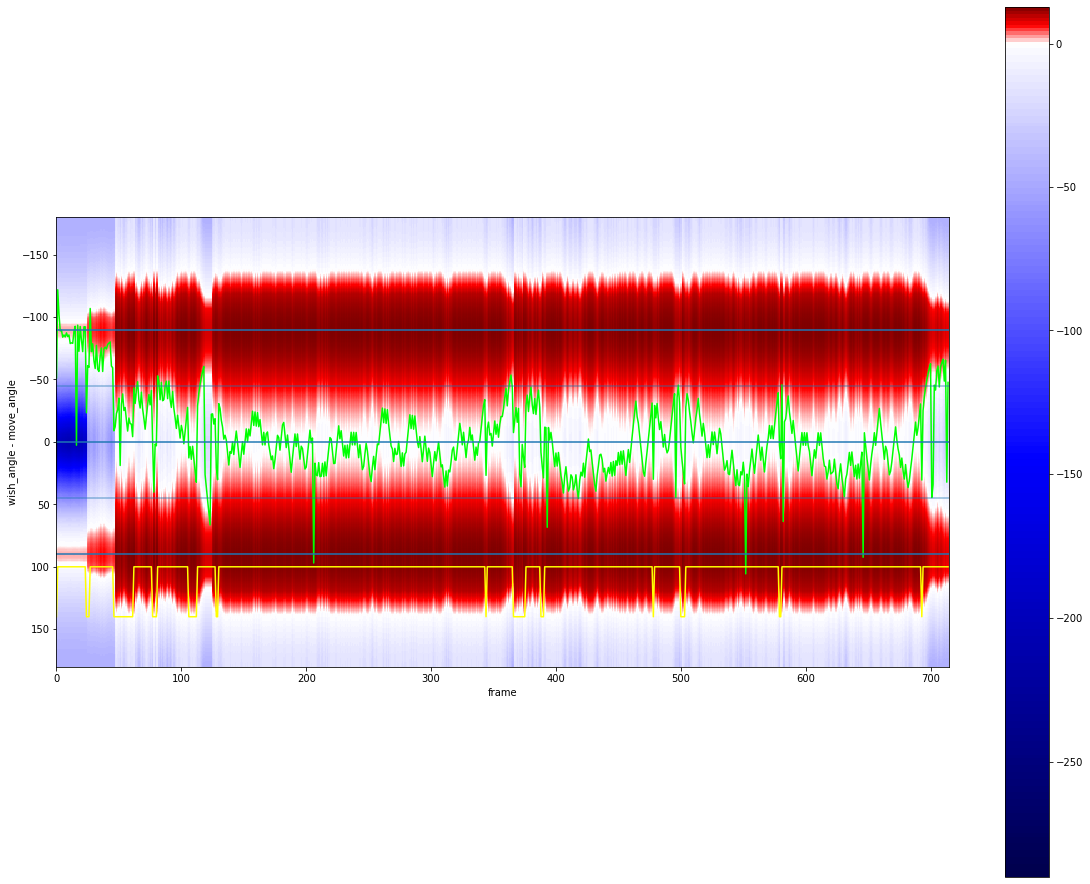

In [6]:
r.wish_angle_yaw_plot()

Plot relative angle with a backing image showing the delta v that would be attained if the relative angle were there

In [7]:
# delta_speeds = []

# move_angle = 180. * np.arctan2(r.player_state.vel[:, 1], r.player_state.vel[:, 0]) / np.pi

# for rel_wish_angle in np.arange(-180, 180):
#     inputs = phys.Inputs(
#         yaw=move_angle + rel_wish_angle,
#         pitch=np.zeros_like(move_angle),
#         roll=np.zeros_like(move_angle),
#         fmove=np.full_like(move_angle, 800.),
#         smove=np.zeros_like(move_angle),
#         button2=r.player_state.vel[:, 2] <= 16,
#         time_delta=np.full_like(move_angle, 0.014),
#     )
#     speed_before = np.linalg.norm(r.player_state.vel[:, :2], axis=1)
#     next_player_state = phys.apply(inputs, r.player_state)
#     speed_after = np.linalg.norm(next_player_state.vel[:, :2], axis=1)
    
#     delta_speeds.append(speed_after - speed_before)
    
# delta_speeds = np.stack(delta_speeds)

In [8]:
# from matplotlib import colors

# wish_angle = r.yaw + (180. * np.arctan2(r.smove, r.fmove) / np.pi)

# vmin = np.min(delta_speeds)
# vmax = np.max(delta_speeds)
# norm = colors.DivergingNorm(vmin=vmin, vcenter=0., vmax=vmax)

# plt.figure(figsize=(20, 16))
# plt.ylim(180, -180)
# plt.ylabel('wish_angle - move_angle')
# plt.xlabel('frame')

# # c = 100 * (delta_speeds > 0)
# c = delta_speeds
# plt.imshow(c, cmap='seismic', norm=norm,
#            extent=(0, delta_speeds.shape[1], 180, -180)
#           )
# plt.plot(wish_angle - move_angle, color='#00ff00')
# plt.axhline(0)
# plt.axhline(90)
# plt.axhline(-45, alpha=0.5)
# plt.axhline(45, alpha=0.5)
# plt.axhline(-90)

# plt.colorbar()

# plt.plot(r.fmove / 20 + 100, color='#ffff00')

# plt.show()

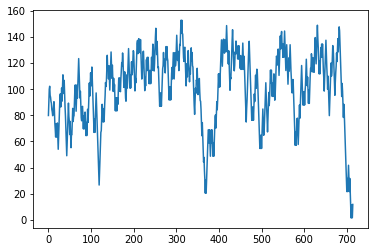

In [9]:
plt.plot(r.yaw)

In [10]:
# Why is the peak ground increase not at angle = 0?

Plot max attainable delta-v against obtained delta-v

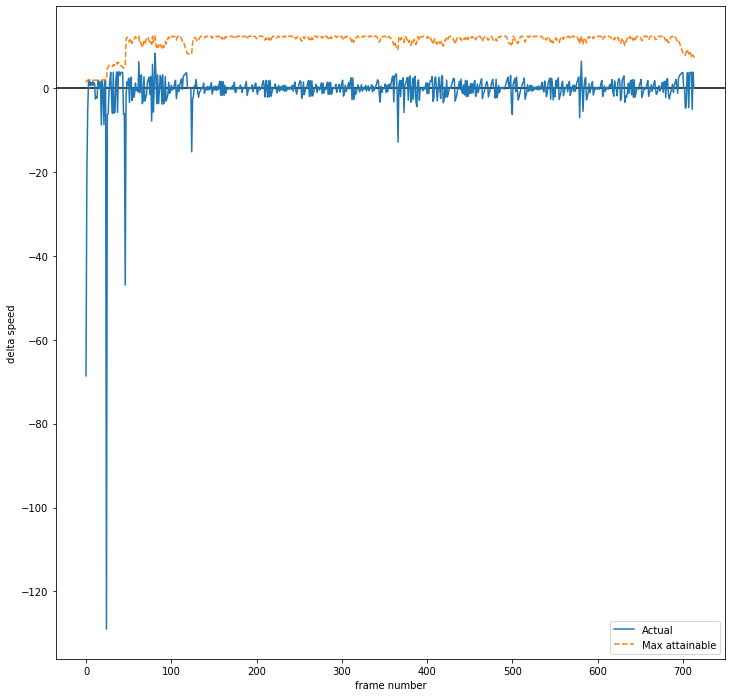

In [11]:
plt.figure(figsize=(12, 12))
plt.axhline(0, color='black')
plt.xlabel('frame number')
plt.ylabel('delta speed')
plt.plot(np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1)), label='Actual')
plt.plot(np.max(r.hypothetical_delta_speeds, axis=0), label='Max attainable', linestyle='--')
plt.legend()

Velocity over time

2020-03-09 09:36:24,931	ERROR worker.py:998 -- Possible unhandled error from worker: ray::RolloutWorker (pid=6942, ip=192.168.43.49)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/home/matt/ray/python/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node matt-ThinkPad-X1-Carbon is used (7.42 / 7.69 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
10900	0.57GiB	/usr/lib/firefox/firefox
6863	0.46GiB	/home/matt/.virtualenvs/100m-rl/bin/python3 -m ipykernel_launcher -f /home/matt/.local/share/jupyter
2971	0.41GiB	tmux
6942	0.37GiB	ray::RolloutWorker
6941	0.37GiB	ray::RolloutWorker
6944	0.37GiB	ray::RolloutWorker.__init__()
6943	0.37GiB	ray::RolloutWorker.__init__()
26439	0.29GiB	/usr/lib/firefox/firefox -contentproc -childID 16 -isForBrowser -prefsLen 12695 -prefMapSize 203234
2225	0.24GiB	/usr/bin/ibus-daemon --daemonize --xim --address unix:tmpd

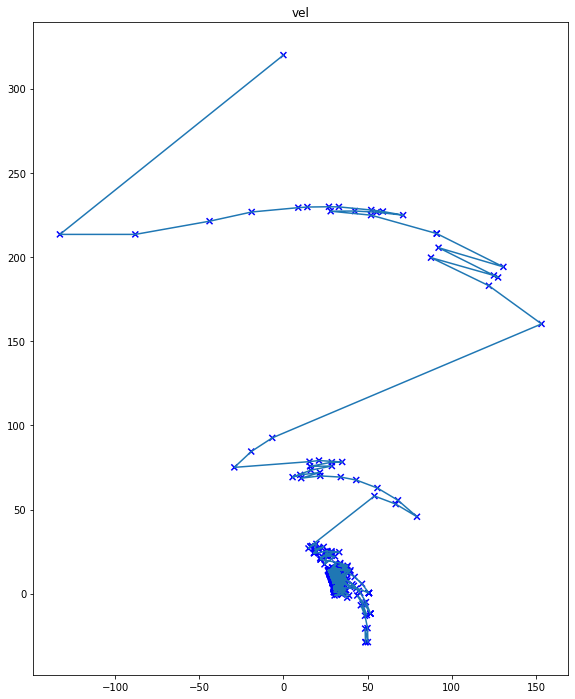

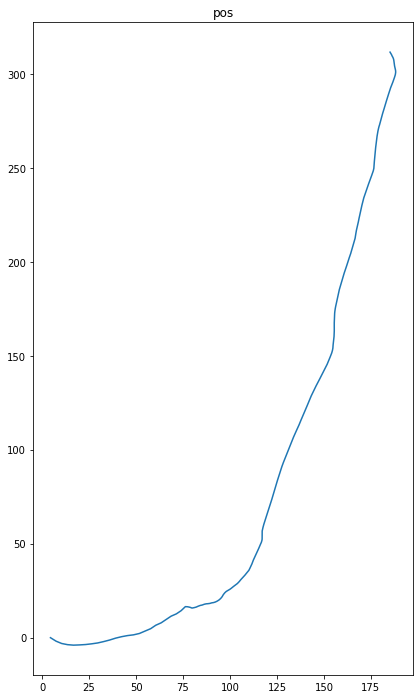

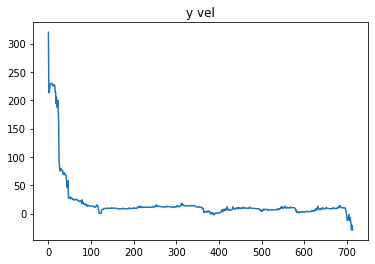

In [12]:
vel = r.player_state.vel
pos = np.cumsum(vel, axis=0) * 0.014

plt.figure(figsize=(12, 12))
plt.axes().set_aspect('equal')
plt.title('vel')
plt.plot(vel[:, 0], vel[:, 1])
c = np.where(np.concatenate([np.diff(vel[:, 2] > 1e-2), [False]]),
             'red', 'blue')
plt.scatter(vel[:, 0], vel[:, 1], c=c, marker='x')
plt.show()

plt.figure(figsize=(12, 12))
plt.axes().set_aspect('equal')
plt.title('pos')
plt.plot(pos[:, 1], pos[:, 0])
plt.show()

plt.title('y vel')
plt.plot(vel[:, 1])

Per-frame attainable delta speed given relative angle, with actual angle, delta speed plotted

In [13]:
FRAME_NUM = 55

2020-03-09 09:36:25,940	ERROR worker.py:998 -- Possible unhandled error from worker: ray::RolloutWorker (pid=6944, ip=192.168.43.49)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/home/matt/ray/python/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node matt-ThinkPad-X1-Carbon is used (7.42 / 7.69 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
10900	0.57GiB	/usr/lib/firefox/firefox
6863	0.46GiB	/home/matt/.virtualenvs/100m-rl/bin/python3 -m ipykernel_launcher -f /home/matt/.local/share/jupyter
2971	0.41GiB	tmux
6941	0.37GiB	ray::RolloutWorker
6942	0.37GiB	ray::RolloutWorker
6944	0.37GiB	ray::RolloutWorker
6943	0.37GiB	ray::RolloutWorker.__init__()
26439	0.29GiB	/usr/lib/firefox/firefox -contentproc -childID 16 -isForBrowser -prefsLen 12695 -prefMapSize 203234
2225	0.24GiB	/usr/bin/ibus-daemon --daemonize --xim --address unix:tmpdir=/tmp/ibu

0 / 715
1 / 715
2 / 715
3 / 715
4 / 715
5 / 715
6 / 715
7 / 715
8 / 715
9 / 715
10 / 715
11 / 715
12 / 715
13 / 715
14 / 715
15 / 715
16 / 715
17 / 715
18 / 715
19 / 715
20 / 715
21 / 715
22 / 715
23 / 715
24 / 715
25 / 715
26 / 715
27 / 715
28 / 715
29 / 715
30 / 715
31 / 715
32 / 715
33 / 715
34 / 715
35 / 715
36 / 715
37 / 715
38 / 715
39 / 715
40 / 715
41 / 715
42 / 715
43 / 715
44 / 715
45 / 715
46 / 715
47 / 715
48 / 715
49 / 715
50 / 715
51 / 715
52 / 715
53 / 715
54 / 715
55 / 715
56 / 715
57 / 715
58 / 715
59 / 715
60 / 715
61 / 715
62 / 715
63 / 715
64 / 715
65 / 715
66 / 715
67 / 715
68 / 715
69 / 715
70 / 715
71 / 715
72 / 715
73 / 715
74 / 715
75 / 715


KeyboardInterrupt: 

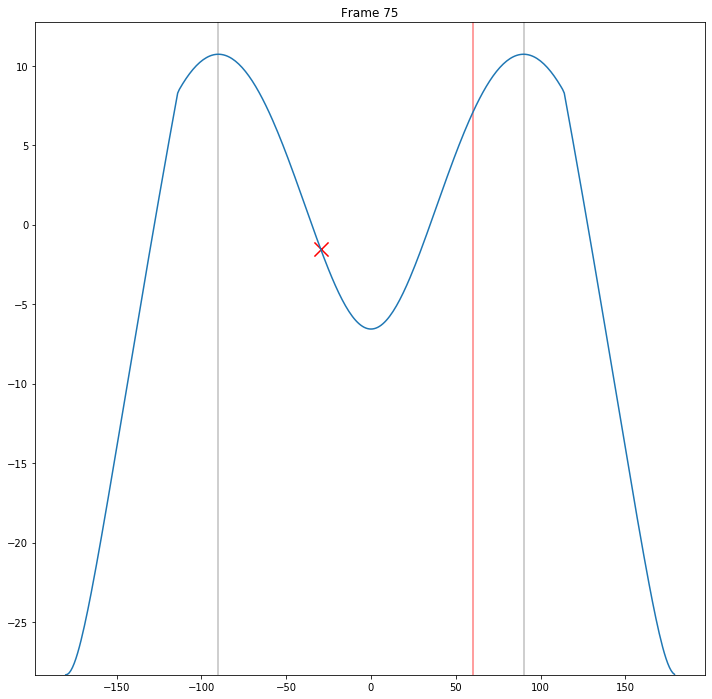

In [14]:

delta_speeds = r.hypothetical_delta_speeds
wish_angle = r.wish_angle
move_angle = r.move_angle
num_frames = wish_angle.shape[0]

for FRAME_NUM in range(num_frames):
    print(FRAME_NUM, '/', num_frames)
    fig = plt.figure(figsize=(12, 12))
    plt.title(f'Frame {FRAME_NUM}')
    plt.ylim(np.min(delta_speeds[:, FRAME_NUM]),
             np.maximum(4, np.max(delta_speeds[:, FRAME_NUM]) + 2))
    plt.axvline(-90, color='gray', alpha=0.5)
    plt.axvline(90, color='gray', alpha=0.5)
    plt.axvline((r.yaw - move_angle)[FRAME_NUM], color='red', alpha=0.5)
    plt.plot(np.arange(-180, 180), delta_speeds[:, FRAME_NUM])

    plt.scatter((wish_angle - move_angle)[FRAME_NUM],
                np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1))[FRAME_NUM],
                marker='x',
                s=200, color='red')

    plt.savefig(f'anim_frames/{FRAME_NUM:03d}.png', dpi=72 * 2)
    plt.close(fig)

In [ ]:
#Blank space to avoid scrolling when the above image redraws











































